## Importing Packages

In [0]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import pandas as pd

In [0]:
# filter = ['Person'] #[cat,bycycle]
# filter = ['dog', 'bird']

# please replace with the location on your laptop where you unpacked the tarball
voc_root_folder = "C:/Users/Sumi/Desktop/NOTES SEM2/Computer Vision/CV Project/VOCdevkit/"
image_size = 192

### Loading Train and Validation files

In [0]:
# get train and validation files 
train_filepath = os.path.join(voc_root_folder, "VOC2009/ImageSets/Segmentation/train.txt") 
val_filepath = os.path.join(voc_root_folder, "VOC2009/ImageSets/Segmentation/val.txt")

train_files = []
val_files =[]

with open(train_filepath,'r') as f:
    train_files = [l[0:-1] for l in f.readlines()]

with open(val_filepath,'r') as f:
    val_files = [l[0:-1] for l in f.readlines()] 
    
print(len(train_files),len(val_files))

749 750


### Crops images of specific size for 2 reasons
1. reducing size of images
2. more images available for training

In [0]:
def random_crop(image, target,crop_size):
    height, width = image.shape[:2]
    dy, dx = crop_size
    if width < dx or height < dy:
        return None,None
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return image[y:(y+dy), x:(x+dx),:], target[y:(y+dy), x:(x+dx),:]

### Building similar size dataset for input and target images

In [0]:
def build_segmentation_dataset(list_of_files):
    y =[]
    x=[]
    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    targetClass_folder = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/") 
    image_filepaths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file[:-4] in list_of_files]
    targetClass_filepaths = [os.path.join(targetClass_folder, c_f) for c_f in os.listdir(targetClass_folder) if c_f[:-4] in list_of_files]
    images = np.array([io.imread(img_f) for img_f in image_filepaths])
    target = np.array([io.imread(img_f) for img_f in targetClass_filepaths])
    for img_f,target_f in zip(images,target):
        for i in range(2): 
            x1, y1 = random_crop(img_f, target_f,(image_size,image_size))
            if (y1 is not None):
                if (y1.shape == (image_size,image_size,4)):
                    if (np.mean(np.sum(y1,axis = 2)) != 255.0):
                        x.append(x1)
                        y.append(y1)
                    
    x = np.array([img_f for img_f in x]).astype('float32')
    y = np.array([(np.sum(img_f ,axis=2) != np.max(img_f)).astype(int) + (np.sum(img_f ,axis=2) != 895).astype(int) for img_f in y]).astype("float32")
  
    return x, y

### Loading Images and targets of segmentation

In [0]:
x = [] # Input images
y = [] # Target images

image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
targetClass_folder = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/") 

image_filepaths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file[:-4] in train_files]
targetClass_filepaths = [os.path.join(targetClass_folder, classfile) for classfile in os.listdir(targetClass_folder) if classfile[:-4] in train_files]
images = np.array([io.imread(img_f) for img_f in image_filepaths])
target = np.array([io.imread(img_f) for img_f in targetClass_filepaths])


Cropping the images and targets to specific size (192)

In [0]:
#img_f 3 channels, target_f 4 layers
for img_f,target_f in zip(images,target): 
    for i in range(2): 
        x1, y1 = random_crop(img_f, target_f,(image_size,image_size))
        if (y1 is not None):
            if ((y1.shape[0] == image_size) & (y1.shape[1] == image_size) & (y1.shape[2] == 4)):
                # To check each layer has one channel as black and rest all white
                if (np.mean(np.sum(y1,axis = 2)) != 255.0):
                    x.append(x1)
                    y.append(y1)

In [0]:
# x contains cropped input images for segmentation
x[0].shape

(192, 192, 3)

In [0]:
# y contains cropped target images for segmentation ( with black and white layers)
y[0].shape

(192, 192, 4)

In [0]:
img_f.shape

(375, 500, 3)

### Getting training and validation data for segmentation

In [0]:
train_files[10]

'2007_000333'

In [0]:
x_train, y_train = build_segmentation_dataset(train_files)
x_val, y_val = build_segmentation_dataset(val_files)

In [0]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((1385, 192, 192, 3), (1385, 192, 192), (1429, 192, 192, 3), (1429, 192, 192))

In [0]:
# normalization
x_train = x_train / np.max(x_train)
x_val = x_val / np.max(x_val)
y_train = y_train -1 
y_val = y_val -1
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(1385, 192, 192, 3) (1385, 192, 192)
(1429, 192, 192, 3) (1429, 192, 192)


In [0]:
# to increase training data, using some data from validation
x_train = np.vstack([x_train,x_val[0:600]])
y_train = np.vstack([y_train,y_val[0:600]])
x_val = x_val[600:]
y_val = y_val[600:]
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(1985, 192, 192, 3) (1985, 192, 192)
(829, 192, 192, 3) (829, 192, 192)


In [0]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(1985, 192, 192, 3) (1985, 192, 192)
(829, 192, 192, 3) (829, 192, 192)


## Saving training and validation data to pickle files to run in colab

In [0]:
X_TrainCopy = x_train.copy()

train_images = []
for i in range(len(X_TrainCopy)):
    train_images.append(X_TrainCopy[i])

train_classes = []
for i in range(len(y_train)):
    train_classes.append(y_train[i])


In [0]:
X_Train_df = pd.DataFrame()
X_Train_df['Image_Array'] = train_images
X_Train_df['Target_Array'] = train_classes

# # Reshuffle the images & it's respective class labels
# X_Train_df = X_Train_df.sample(frac=1).reset_index(drop=True)  

X_Train_df.to_pickle('X_Train_'+str(image_size)+'.pkl') #Save the file as pickle
print('Saved the training images into pickle file')
print(X_Train_df.shape)
X_Train_df.head()

Saved the training images into pickle file
(1985, 2)


,Image_Array,Target_Array
0,"[[[0.8156863, 0.9882353, 1.0], [0.8156863, 0.9...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[[0.84705883, 0.9647059, 0.91764706], [0.8470...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[[0.62352943, 0.627451, 0.5647059], [0.635294...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[[0.7529412, 0.77254903, 0.7490196], [0.74509...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,"[[[0.2, 0.29411766, 0.20784314], [0.13725491, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [0]:
X_ValCopy = x_val.copy()
val_images = []
for i in range(len(X_ValCopy)):
    val_images.append(X_ValCopy[i])
val_classes = []
for i in range(len(y_val)):
    val_classes.append(y_val[i])

In [0]:
X_Val_df = pd.DataFrame()
X_Val_df['Image_Array'] = val_images
X_Val_df['Target_Array'] = val_classes

X_Val_df.to_pickle('X_Val_'+str(image_size)+'.pkl') #Save the file as pickle
print('Saved the validation and test images into pickle')
print(X_Val_df.shape)
X_Val_df.head()

Saved the validation and test images into pickle
(829, 2)


,Image_Array,Target_Array
0,"[[[0.3529412, 0.5411765, 0.6901961], [0.356862...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[[0.34509805, 0.5411765, 0.6862745], [0.34509...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[[0.5019608, 0.5764706, 0.5686275], [0.478431...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[[0.6901961, 0.6, 0.43529412], [0.69411767, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[[0.28235295, 0.30980393, 0.1882353], [0.2156...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Running in COLAB

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/Colab\ Notebooks/Computer\ Vision/
# pwd

/content/drive/My Drive/Colab Notebooks/Computer Vision


### Loading Pickle files

In [0]:
image_size = 192

train_df = pd.read_pickle('X_Train_192.pkl')
x_train = np.array(train_df['Image_Array'].values.tolist())
y_train = np.array(train_df['Target_Array'].values.tolist())

val_df = pd.read_pickle('X_Val_192.pkl')
x_val = np.array(val_df['Image_Array'].values.tolist())
y_val = np.array(val_df['Target_Array'].values.tolist())


In [4]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1985, 192, 192, 3) (1985, 192, 192)
(829, 192, 192, 3) (829, 192, 192)


In [81]:
y_val[5]

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

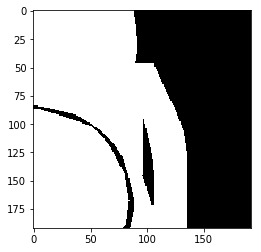

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.imshow((y_train[5]),cmap="gray")

In [6]:
import keras
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf

Using TensorFlow backend.


In [0]:
def cnn_net(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 
    
    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

In [9]:
# segmentation model 
from datetime import datetime 
input_img = Input(shape=(image_size, image_size, 3))
autoencoder = Model(input_img, cnn_net(input_img))
autoencoder.summary()

W0901 19:15:30.180411 139660259399552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 19:15:30.182694 139660259399552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 19:15:30.190085 139660259399552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 19:15:30.212976 139660259399552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0901 19:15:30.277583 139660259399552 deprecation_wrapp

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0   

#### Dice Score
It is a statistic used to gauge the similarity of two samples.
https://dev.to/andys0975/what-is-dice-loss-for-image-segmentation-3p85

In [0]:
def dice_score(y_true, y_pred):
    return tf.reduce_mean(dice_coef(y_true, y_pred))

  
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

In [0]:
adam = Adam(lr=0.06)

In [76]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

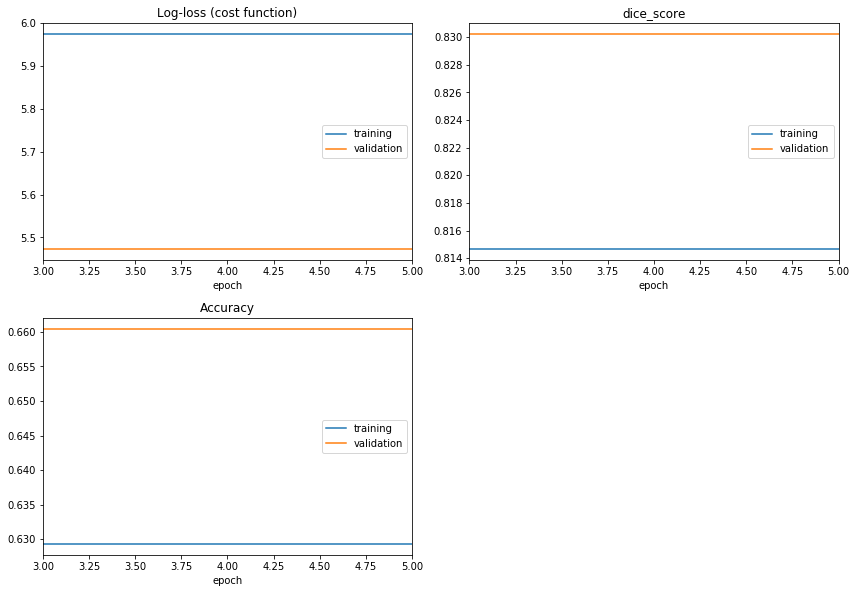

Log-loss (cost function):
training   (min:    5.975, max:    5.975, cur:    5.975)
validation (min:    5.472, max:    5.472, cur:    5.472)

dice_score:
training   (min:    0.815, max:    0.815, cur:    0.815)
validation (min:    0.830, max:    0.830, cur:    0.830)

Accuracy:
training   (min:    0.629, max:    0.629, cur:    0.629)
validation (min:    0.660, max:    0.660, cur:    0.660)
Time elapsed (hh:mm:ss.ms) 0:03:25.721903


In [82]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=[dice_score, 'accuracy'])
start_time = datetime.now() 
history = autoencoder.fit(x_train, y_train[:,:,:,np.newaxis],
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val[:,:,:,np.newaxis]),
                callbacks=[PlotLossesKeras(), 
                ModelCheckpoint(filepath='bin_cross' + '.h5', monitor='val_loss', save_best_only=True)])

print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

#### Loss Functions
Reference: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [0]:
def weighted_cross_entropy(weights):
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
      return tf.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=weights)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

  return loss

In [0]:
def balanced_cross_entropy(weights):
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight = weights / (1 - weights)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss * (1 - weights))

  return loss

Reference: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [0]:
def combined_loss(weights):
    def convert_to_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        return tf.log(y_pred / (1 - y_pred))

    def loss(y_true, y_pred):
        y_pred = convert_to_logits(y_pred)
        loss1 = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=weights))
        loss2 = dice_loss(y_true, y_pred) 
        return tf.reduce_mean(loss1 + loss2)

    return loss
    

In [65]:
autoencoder.compile(optimizer=adam, loss=weighted_cross_entropy(2), metrics=[dice_score, 'accuracy'])
start_time = datetime.now() 
history = autoencoder.fit(x_train, y_train[:,:,:,np.newaxis],
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val[:,:,:,np.newaxis]))
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Train on 1985 samples, validate on 829 samples
Epoch 1/30
1985/1985 [==============================] - 41s 20ms/step - loss: 11.9501 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 10.9448 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 2/30
1985/1985 [==============================] - 39s 20ms/step - loss: 11.9501 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 10.9448 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 3/30
1985/1985 [==============================] - 39s 20ms/step - loss: 11.9501 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 10.9448 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 4/30
1985/1985 [==============================] - 39s 20ms/step - loss: 11.9501 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 10.9448 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 5/30
1985/1985 [==============================] - 39s 20ms/step - loss: 11.9501 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 10.9448 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 6/30
1985/1985 [===========

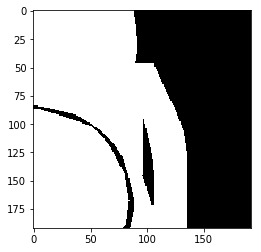

In [83]:
plt.imshow(y_train[5],cmap="gray")

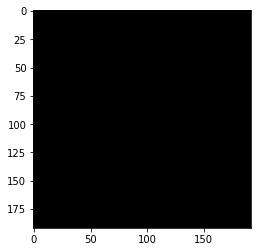

In [85]:
# visualize outputs:
pred = autoencoder.predict(x_train[5:6])
plt.imshow(pred[0][:,:,0],cmap="gray")

auc: 0.5


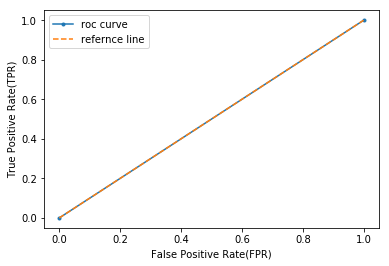

In [86]:
# 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

pred = autoencoder.predict(x_train[0:50])
auc = roc_auc_score(y_train[0:50].flatten().astype("int64"), pred.flatten())
fpr, tpr, thresholds = roc_curve(y_train[0:50].flatten().astype("int64"), pred.flatten())

plt.plot(fpr,tpr,marker='.',label='roc curve')
plt.plot([0, 1], [0, 1], linestyle='--',label='refernce line')
plt.legend(loc='upper left')
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

print("auc: "+str(auc))

Reference: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['val_loss', 'val_dice_score', 'val_acc', 'loss', 'dice_score', 'acc'])


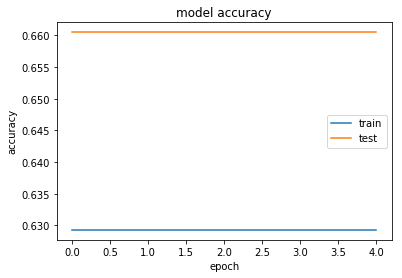

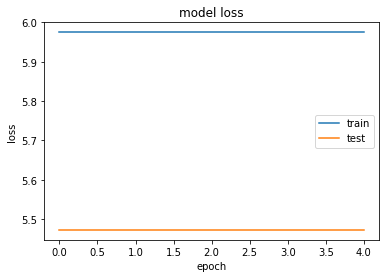

In [87]:
# plot learning curve 
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [35]:
autoencoder.compile(optimizer=adam, loss=combined_loss(2), metrics=[dice_score, 'accuracy'])
start_time = datetime.now() 
history = autoencoder.fit(x_train, y_train[:,:,:,np.newaxis],
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val[:,:,:,np.newaxis]))
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Train on 1985 samples, validate on 829 samples
Epoch 1/30
1985/1985 [==============================] - 41s 21ms/step - loss: 12.9006 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 11.8992 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 2/30
1985/1985 [==============================] - 40s 20ms/step - loss: 12.9006 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 11.8992 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 3/30
1985/1985 [==============================] - 40s 20ms/step - loss: 12.9006 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 11.8992 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 4/30
1985/1985 [==============================] - 40s 20ms/step - loss: 12.9006 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 11.8992 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 5/30
1985/1985 [==============================] - 40s 20ms/step - loss: 12.9006 - dice_score: 0.8146 - acc: 0.6293 - val_loss: 11.8992 - val_dice_score: 0.8302 - val_acc: 0.6605
Epoch 6/30
1985/1985 [===========

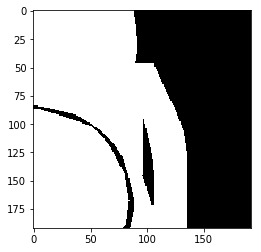

In [36]:
plt.imshow((y_train[5]),cmap="gray")

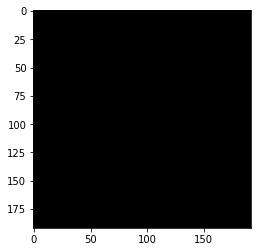

In [41]:
# visualize outputs:
pred = autoencoder.predict(x_train[100:101])
plt.imshow(pred[0][:,:,0],cmap="gray")

In [48]:
np.where(pred[0]!=0)
#All dark output

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

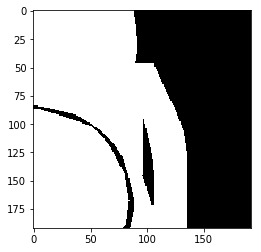

In [49]:
plt.imshow(y_train[5],cmap="gray")

#### ROC Curve

auc: 0.5


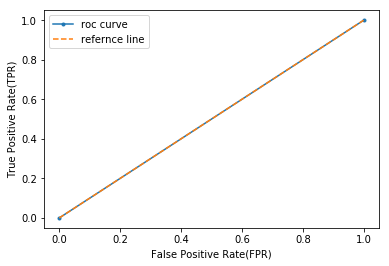

In [52]:
# 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

pred = autoencoder.predict(x_train[0:50])
auc = roc_auc_score(y_train[0:50].flatten().astype("int64"), pred.flatten())
fpr, tpr, thresholds = roc_curve(y_train[0:50].flatten().astype("int64"), pred.flatten())

plt.plot(fpr,tpr,marker='.',label='roc curve')
plt.plot([0, 1], [0, 1], linestyle='--',label='refernce line')
plt.legend(loc='upper left')
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

print("auc: "+str(auc))

#### F1 Score

In [55]:
thresh = 0.5
f1 = f1_score(y_train[0:50].flatten().astype("int64"), np.array(pred > thresh).flatten())
print("f1 score: "+str(f1))

f1 score: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Precision-Recall Curve

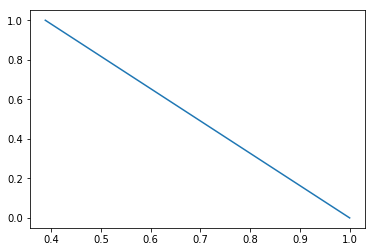

In [57]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_train[0:50].flatten().astype("int64"), np.array(pred > thresh).flatten())
plt.plot(precision,recall)

#### Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train[0:50].flatten().astype("int64"), np.array(pred >= thresh).flatten())

array([[1127451,       0],
       [ 715749,       0]])

#### Learning Curve

dict_keys(['val_loss', 'val_dice_score', 'val_acc', 'loss', 'dice_score', 'acc'])


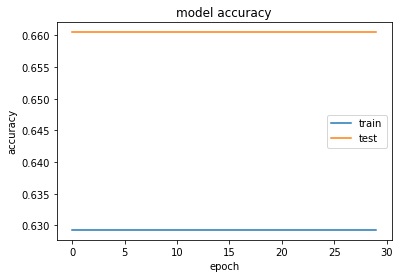

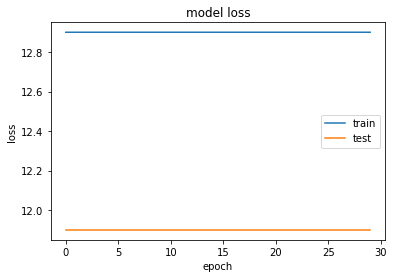

In [61]:
# plot learning curve 
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [0]:
# model_json = autoencoder.to_json()
# with open("seg1.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# autoencoder.save_weights("seg1.h5")
# autoencoder.save('seg1-20Epoch.h5')

from keras.models import model_from_json
json_file = open('seg1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("seg1.h5")

In [0]:
loaded_model = keras.models.load_model("seg1-20Epoch.h5")

Instructions for updating:
Use tf.cast instead.


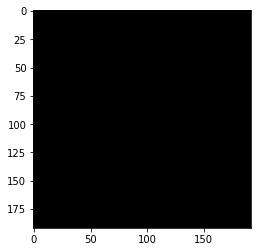

In [64]:
plt.imshow(y_train[35],cmap="gray")